In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

import os
import torch
import numpy as np
from datasets import load_from_disk

%matplotlib inline
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
def load_predictions(model, dataset_name):
    """
        load the prediction file
        Example: {"opt_125m": {"opt_125m_2000": Dataset({"prompt_tokens": [], "positional_scores": []})}}
            - prompt_tokens: list of prompt tokens
            - positional_scores: list of next-token prediction scores (log-likelihood)
    """
    loc = f"data/{model}/validationlm__{dataset_name}_predictions.pt"
    preds = load_from_disk(loc)
    return preds

In [5]:
dataset_name = "gutenberg_pg-19"

# load perplexity, log-likelihood, and steps of all models
# shape: {model: (num_tokens, num_steps)}
all_ppls = torch.load(f"data/trend_of_tokens/all_ppls-{dataset_name}.pt")
all_scores = torch.load(f"data/trend_of_tokens/all_scores-{dataset_name}.pt")
all_steps = torch.load(f"data/trend_of_tokens/all_steps-{dataset_name}.pt")

In [6]:
def select_tokens_based_on_trend(all_scores: np.array, threshold: float, cond:int=1):
    """
        return the gate, gated_mean, and the selected scores
        Input:
            - all_scores: the log-likelihood scores of all tokens, shape: (num_tokens, num_steps)
            - threshold: the threshold (training percentage) to select the tokens, 
            - cond: the condition to select the tokens, 1: stagnated, 2: upward trend, 3: downward trend
        Output:
            - gate: the gate of the selected tokens, shape: (num_tokens,)
            - gated_mean: the mean of the log-likelihood of selected tokens, shape: (num_selected_tokens,)
            - selected_ppls: the selected scores, shape: (num_selected_tokens, num_steps)
    """
    def cond1(x): # stagnated
        m = np.exp(np.nanmean(np.log(x), axis=1))
        var = x.var(axis=1)
        m_condition = (m / x[:, 0] > 0.95) & (m / x[:, 0] < 1.05) & (m / x[:, -1] > 0.95) & (m / x[:, -1] < 1.05)
        v_condition = var < m
        return m_condition & v_condition 

    def cond2(x): # upward trend
        m = np.nanmean(x, axis=1)
        m_condition = (m / x[:, 0] > 1.05) & (m / x[:, -1] < 0.95)
        return m_condition
    
    def cond3(x): # downward trend
        m = x.mean(axis=1)
        return (m / x[:, 0] < 0.95) & (m / x[:, -1] > 1.05)

    mapps = {1: cond1, 2: cond2, 3: cond3}
    threshold = int(threshold * all_scores.shape[1])

    gate = mapps[cond](all_scores[:, threshold:])
    gated_mean = np.nanmean(all_scores[:, threshold:], axis=1)[gate]
    selected_ppls = all_scores[gate]
    return gate, gated_mean, selected_ppls

In [7]:
from utils import return_opt_model_sizes

def load_linear_trend(dataset_name):
    """
        load the linear trend of tokens
        Output:
            - linear_trend: the linear trend of tokens, {"opt_125m": {threshold: {"params": np.array, "pvalues: np.array}}}
                shape of params, pvalues: (num_tokens, 2), the first column is the intercept, the second column is the slope 
    """
    linear_trend = {}
    for model_size in return_opt_model_sizes():
        file = f"data/trend_of_tokens/linear_trend/slo-{dataset_name}-{model_size}-simple.pt"
        if os.path.exists(file):
            linear_trend[model_size] = torch.load(file)
    return linear_trend

In [8]:
def classify_trends(linear_trend, verbose=False):
    """ 
        return a mask for each trend type for each threshold
    """
    conds = {}
    for model_size in linear_trend:
        conds[model_size] = {}
        for threshold in linear_trend[model_size]:
            ols_re = linear_trend[model_size][threshold]
            coef = ols_re["params"][:, 1]
            pvalues = ols_re["pvalues"][:, 1]

            values = all_ppls[model_size]
            increase_cond = ((coef > 0) & (pvalues < 0.05)) 
            decrease_cond = ((coef < -0) & (pvalues < 0.05)) 

            stagnate_cond, _, _ = select_tokens_based_on_trend(values, threshold, 1)
            stagnate_cond = stagnate_cond & (~increase_cond) & (~decrease_cond)

            increase = increase_cond.sum() / len(increase_cond)
            decrease =decrease_cond.sum() / len(decrease_cond)
            stagnate = stagnate_cond.sum() / len(stagnate_cond)
            conds[model_size][threshold] = {1: stagnate_cond, 2: increase_cond, 3: decrease_cond}
            if verbose:
                print(f"{model_size} {threshold} {stagnate} {increase} {decrease}")
    return conds


### Plot percentage of tokens for each trend

/tmp/ipykernel_261856/3939293358.py:14: RuntimeWarning: Mean of empty slice
  m = np.exp(np.nanmean(np.log(x), axis=1))
/tmp/ipykernel_261856/3939293358.py:33: RuntimeWarning: Mean of empty slice
  gated_mean = np.nanmean(all_scores[:, threshold:], axis=1)[gate]


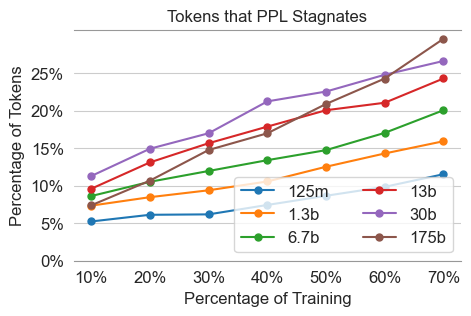

In [9]:
from utils import return_color

linear_trend = load_linear_trend(dataset_name)
conds = classify_trends(linear_trend)

sns.set_style("whitegrid")
fig, ax = plt.subplots(1, 1, figsize=(5, 3))

trend_id = 1
trend_names = {1: "Stagnates", 2: "Increases", 3: "Decreases"}

for model_size in conds:
    xs = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
    ys = [conds[model_size][x][trend_id].sum() / len(conds[model_size][x][trend_id]) for x in xs]
    ax.plot(xs, ys, label=model_size.split("_")[1], marker="o", color=return_color(model_size), markersize=5)
if trend_id == 1:
    plt.legend(fontsize=12, ncol=2, loc="lower right")

ax.set_title(f"Tokens that PPL {trend_names[trend_id]}", fontsize=12)
ax.set_xlabel("Percentage of Training", fontsize=12)
ax.set_ylabel("Percentage of Tokens", fontsize=12)
ax.set_xticks(xs, ["10%", "20%", "30%", "40%", "50%", "60%", "70%"], fontsize=12)

if trend_id == 1:
    ax.set_yticks([0, 0.05, 0.1, 0.15, 0.2, 0.25], ["0%", "5%", "10%", "15%", "20%", "25%"], fontsize=12)
elif trend_id == 2:
    ax.set_yticks([0, 0.05, 0.1, 0.15], ["0%", "5%", "10%", "15%"], fontsize=12)
else:
    ax.set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5], ["0%", "10%", "20%", "30%", "40%", "50%"], fontsize=12)

sns.despine(left=True, bottom=False, top=False)
ax.xaxis.grid(False)
ax.spines['top'].set_color('#989898')
ax.spines['bottom'].set_color('#989898')

out_file = f"images/section1/{trend_names[trend_id]}-percentage-{dataset_name}.pdf"
if not os.path.exists(out_file):
    plt.savefig(out_file, bbox_inches='tight')

### Plot perplexity of each type of tokens after p% training of a specific model

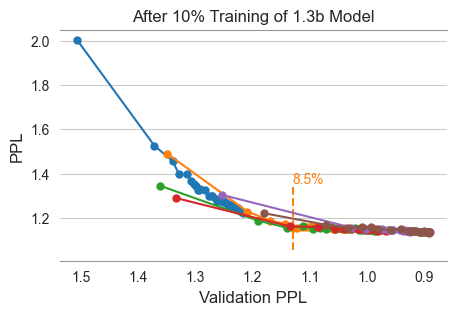

In [24]:
from utils import get_xaxis
    
specific_model = "opt_1.3b" # if None, plot perplexity after p% of training of each model
threshold = 0.2 # plot perplexity after 20% training of the specific model
trend_id = 1 # stagnated, upward, downward
xaxis_type = "ppl" # Steps, FLOPs, Tokens
xaxis_log = True

fig, ax = plt.subplots(1, 1, figsize=(5, 3))

if xaxis_type == "ppl":
    ax.invert_xaxis()
    
y_max = 0
y_min = 0

model_sizes = list(all_ppls.keys())
if specific_model is not None:
    model_sizes.remove(specific_model)
    model_sizes.append(specific_model) # add the specific model to the end of the list
    
for model_id, model_size in enumerate(all_ppls):
    scores = all_scores[model_size]
    steps = all_steps[model_size]
    
    if specific_model is None:
        cond = conds[model_size][threshold][trend_id]
    else:
        cond = conds[specific_model][threshold][trend_id]

    x = get_xaxis(model_size, steps, xaxis_type, xaxis_log)
    ppl = np.exp(-np.nanmean(scores[cond], axis=0))
    ax.plot(x, ppl, label=model_size.split("_")[1], marker="o", color=return_color(model_size), markersize=5)

    y_max = max(y_max, ppl.max()); y_min = min(y_min, ppl.min())
    
    if specific_model == model_size or specific_model is None:
        index = int(len(x) * threshold)
        y = ppl[index]; 
        ymin = y - (y_max - y_min) * 0.05
        ymax = y + (y_max - y_min) * 0.1
        
        ax.vlines(x[index], color=return_color(model_size), linestyle = "--", ymin=ymin, ymax=ymax)
        p = np.round((cond.sum() / len(cond)) * 100, 1)
        ax.annotate(f"{p}%", (x[index], ymax), color=return_color(model_size)) 
       
ax.set_ylabel("PPL", fontsize=12)
if xaxis_type == "ppl":
    ax.set_xlabel("Validation PPL", fontsize=12)
else:
    ax.set_xlabel(xaxis_type, fontsize=12)
    if xaxis_type == "FLOPs":
        FLOPs = range(18, 24)
        ax.set_xticks(list(FLOPs), [f"$10^{{{x}}}$" for x in FLOPs], fontsize=12)

# readjust the threshold 
if specific_model is not None:
    plt.title(f"After 10% Training of {specific_model.split('_')[1]} Model", fontsize=12)
else:
    plt.title(f"After 10% Training of Each Model", fontsize=12)
    
sns.despine(left=True, bottom=False, top=False)
ax.spines['top'].set_color('#989898')
ax.spines['bottom'].set_color('#989898')
ax.xaxis.grid(False)

out_file = f"images/section1/{trend_names[trend_id]}-{specific_model}-{xaxis_type}-{dataset_name}.pdf"
plt.savefig(out_file, bbox_inches='tight')

### Plot a single token's perplexity trend

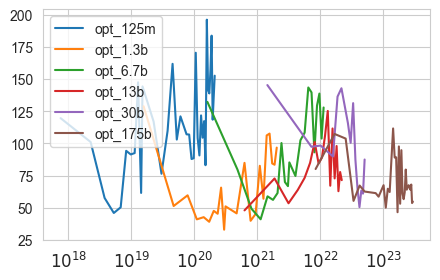

In [95]:
model_size = "opt_1.3b"
threshold = 0.2
trend_id = 2
sample_i = 90

xaxis_type = "FLOPs"
xaxis_log = True

cond = conds[model_size][threshold][trend_id]

fig, ax = plt.subplots(1, 1, figsize=(5, 3))
for model_size in all_ppls: 
    data = all_ppls[model_size][cond][sample_i]
    xs = get_xaxis(model_size, all_steps[model_size], xaxis_type, xaxis_log)
    ax.plot(xs, data, label=model_size)

ys = np.array(all_ppls[model_size][cond][sample_i]).reshape(-1, 1)
ys = ys / ys[0] # normalize

if xaxis_type == "FLOPs":
    FLOPs = range(18, 24)
    ax.set_xticks(list(FLOPs), [f"$10^{{{x}}}$" for x in FLOPs], fontsize=12)
    
plt.legend()